In [37]:
from datasets.idda import IDDADataset
from datasets.idda import showIDDAsample
from models.deeplabv3 import deeplabv3_mobilenetv2
from torch.utils.data import DataLoader
import datasets.ss_transforms as sstr

In [38]:
train_transform=sstr.Compose([sstr.RandomResizedCrop((512,928),scale=(0.5,2)),sstr.ToTensor()])
#sstr.RandomResizedCrop((512,928),scale=(0.5,2))


In [39]:
iddaTrain=IDDADataset('data/idda',fileName='data/idda/train.txt',transform=train_transform)
print(f'Training set size: {iddaTrain.__len__()}')
iddaTestSame=IDDADataset('data/idda',fileName='data/idda/test_same_dom.txt')
print(f'Test set size for same domain: {iddaTestSame.__len__()}')
iddaTestDiff=IDDADataset('data/idda',fileName='data/idda/test_diff_dom.txt')
print(f'Test set size for diff domain: {iddaTestDiff.__len__()}')

Training set size: 600
Test set size for same domain: 120
Test set size for diff domain: 120


In [40]:
train_loader=DataLoader(iddaTrain,batch_size=10,shuffle=True)

In [41]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([10, 3, 512, 928])
Labels batch shape: torch.Size([10, 512, 928])


In [42]:
print(iddaTrain[10])

(tensor([[[0.4471, 0.4471, 0.4471,  ..., 0.0039, 0.0039, 0.0078],
         [0.4510, 0.4471, 0.4471,  ..., 0.0078, 0.0078, 0.0118],
         [0.4549, 0.4549, 0.4510,  ..., 0.0314, 0.0353, 0.0431],
         ...,
         [0.7647, 0.7647, 0.7686,  ..., 0.7882, 0.7882, 0.7922],
         [0.7686, 0.7686, 0.7686,  ..., 0.7922, 0.7922, 0.7961],
         [0.7569, 0.7569, 0.7686,  ..., 0.7922, 0.7922, 0.7922]],

        [[0.5412, 0.5373, 0.5373,  ..., 0.0039, 0.0039, 0.0078],
         [0.5451, 0.5412, 0.5412,  ..., 0.0078, 0.0078, 0.0118],
         [0.5451, 0.5451, 0.5451,  ..., 0.0275, 0.0314, 0.0392],
         ...,
         [0.0000, 0.0000, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
         [0.0000, 0.0039, 0.0196,  ..., 0.0039, 0.0039, 0.0039],
         [0.0000, 0.0118, 0.0392,  ..., 0.0000, 0.0039, 0.0000]],

        [[0.6510, 0.6549, 0.6588,  ..., 0.0039, 0.0039, 0.0078],
         [0.6549, 0.6510, 0.6549,  ..., 0.0078, 0.0078, 0.0118],
         [0.6549, 0.6549, 0.6549,  ..., 0.0275, 0.0314, 0

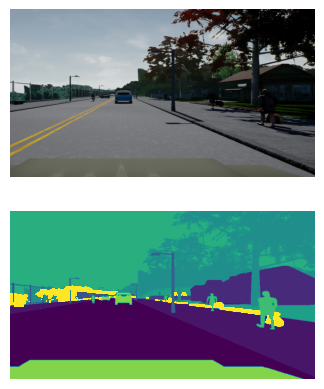

In [58]:
#showing a random sample
showIDDAsample(iddaTrain[140])

In [44]:
import datasets.np_transforms as np_tr

In [45]:
centercrop=np_tr.CenterCrop(1000)
img=centercrop(iddaTrain[140][0])
import matplotlib.pyplot as plt
plt.imshow(img)

TypeError: img should be numpy array. Got <class 'torch.Tensor'>